# Exploratory data analysis of the virtual cell challenge

In [ ]:
# Load packages
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Ensure UMAP coordinates exist
adata.obs['UMAP1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP2'] = adata.obsm['X_umap'][:, 1]

# Compute centroids per target_gene
centroids = (
    adata.obs.groupby('target_gene')[['UMAP1', 'UMAP2']]
    .mean()
)

# Compute pairwise distances between centroids
distances = pdist(centroids.values, metric='euclidean')

# Perform hierarchical clustering
Z = linkage(distances, method='ward')  # Ward’s method minimizes variance within clusters

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=centroids.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.7 * np.max(Z[:, 2])  # Optional: color branches by distance
)
plt.title("Hierarchical clustering dendrogram of centroid distances (UMAP space)")
plt.xlabel("Target Gene (Perturbation)")
plt.ylabel("Euclidean distance")
plt.show()


from pathlib import Path

from eda_toolkit import create_subset_h5ad_by_size

In [10]:
# Create subset of cell and genes
# subset = create_subset_h5ad_by_size(
#     input_path=data_folder,
#     output_path="subset_5000cells_2000genes.h5ad",
#     n_cells=5000,
#     n_genes=2000
# )


In [11]:
# Define directory and files
current_path = Path.cwd().resolve().parent
data_folder = (current_path / 'data' / 'adata_Training.h5ad').resolve()
print(data_folder)
dataset_file = "subset_5000cells_2000genes.h5ad"

C:\Users\mikga\Desktop\S1\DL\DL_VCC\data\adata_Training.h5ad


In [12]:
adata = ad.read_h5ad(data_folder)

In AnnData the main matrix `adata.X` stores gene expression counts. Each entry stores the number of observed transcripts for the cell $i$ adn the gene $j$. 
Is a measure o the sequencing depth per cell, cells with very low total counts could be of poor quality and cells with high total counts could indicate multiple cells captured together. 

The histogram is plotted to assess which low and high thresholds to use.

Maybe we can use this to have a normal distribution on the data if normality could be of any use.

AAACAAGCAACCTTGTACTTTAGG-Flex_1_01     53551.0
AAACAAGCATTGCCGCACTTTAGG-Flex_1_01     23827.0
AAACCAATCAATGTTCACTTTAGG-Flex_1_01     74923.0
AAACCAATCCCTCGCTACTTTAGG-Flex_1_01     39549.0
AAACCAATCTAAATCCACTTTAGG-Flex_1_01     37409.0
                                        ...   
TTTGGACGTGGTGCAGATTCGGTT-Flex_3_16    100998.0
TTTGTGAGTAGTAGCAATTCGGTT-Flex_3_16     54664.0
TTTGTGAGTCCATCCTATTCGGTT-Flex_3_16     64190.0
TTTGTGAGTCCTGACAATTCGGTT-Flex_3_16     25524.0
TTTGTGAGTGGACACGATTCGGTT-Flex_3_16     48080.0
Name: total_counts, Length: 221273, dtype: float32


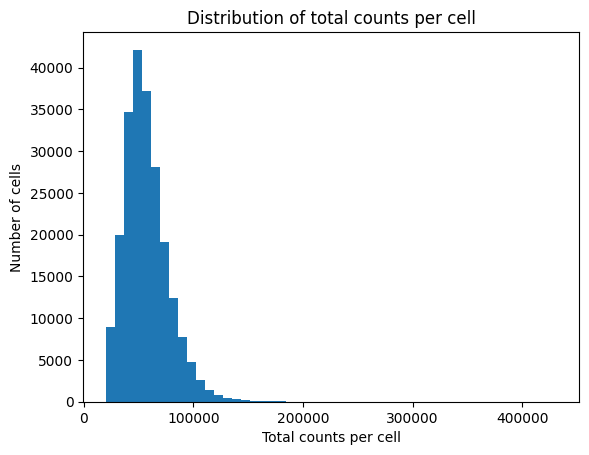

In [13]:
# Compute total counts per cell
adata.obs["total_counts"] = np.array(adata.X.sum(axis=1)).flatten()
print(adata.obs["total_counts"])

plt.hist(adata.obs["total_counts"], bins=50)
plt.xlabel("Total counts per cell")
plt.ylabel("Number of cells")
plt.title("Distribution of total counts per cell")
plt.show()

The total count per gene is the total number of observed transcripts. The next histogram shows the distribution of the level of expression of all genes in the cell set. 
The genes with extremely high count values need to be filtered out to perform PCA o UMAP otherwise they have influence in the varation and can change the scale. Also low gene counts could not be interesting for the analysis as they can be just technical noise. 

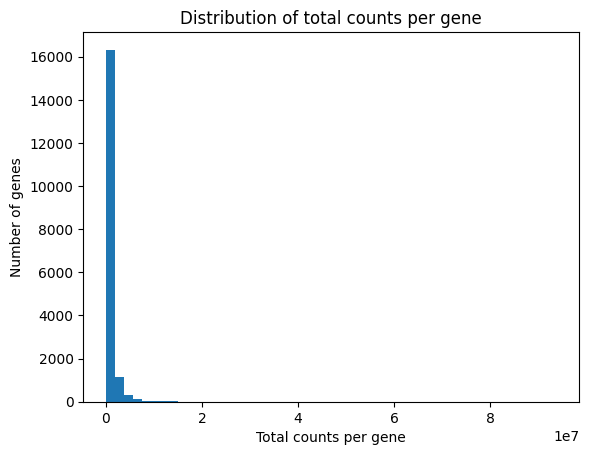

In [14]:

# Compute total expression per gene
adata.var["total_counts"] = np.array(adata.X.sum(axis=0)).flatten()

plt.hist(adata.var["total_counts"], bins=50)
plt.xlabel("Total counts per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of total counts per gene")
plt.show()

The peak at the left of the histogram may indicate genes that are highly variable?

In [15]:
# Number of cells per perturbation
print(adata.obs["target_gene"].value_counts().head(10))

# Number of batches
print(adata.obs["batch"].value_counts())

target_gene
non-targeting    38176
TMSB4X            4760
PRCP              4331
TADA1             4035
HIRA              3407
IGF2R             3109
NCK2              2929
MED13             2787
MED12             2766
STAT1             2493
Name: count, dtype: int64
batch
Flex_3_10    5082
Flex_3_06    5068
Flex_3_15    5038
Flex_3_08    4988
Flex_3_11    4988
Flex_3_14    4980
Flex_3_03    4977
Flex_3_13    4955
Flex_3_04    4936
Flex_3_02    4895
Flex_3_07    4888
Flex_3_09    4834
Flex_3_16    4826
Flex_3_05    4825
Flex_2_13    4718
Flex_2_15    4716
Flex_2_06    4680
Flex_2_11    4673
Flex_3_01    4645
Flex_3_12    4627
Flex_2_14    4614
Flex_2_04    4575
Flex_1_13    4575
Flex_1_06    4565
Flex_1_15    4548
Flex_2_02    4527
Flex_2_10    4526
Flex_1_10    4512
Flex_2_01    4501
Flex_2_03    4499
Flex_2_08    4493
Flex_2_05    4472
Flex_2_07    4452
Flex_1_11    4449
Flex_1_08    4438
Flex_2_09    4434
Flex_2_16    4427
Flex_1_04    4406
Flex_1_07    4398
Flex_1_05    4386
Flex_1

Uniform Manifold Approximation and Projection (UMAP) is a method to applied to single-cell RNA-seq for high-dimensional datasets.

Generaly speaking, it can be assumed that points that are close and form the same cluster belong to similar cell types but separated cell subtypes 

Notice that in order to get the UMAP plot some previous steps need to be perform. UMAP assumes all datapoints are evenly distributed, which is highly unlikely in big datasets.

In our project, the goal with this plot is to see which cells recieved the same perturbation , detect outliers that might be the result of technical issues during data collection And understand the global structure for clustering, modeling or Differential Expression Analysis.


c:\Users\mikga\AppData\Local\Programs\Python\Python313\Lib\functools.py:931: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


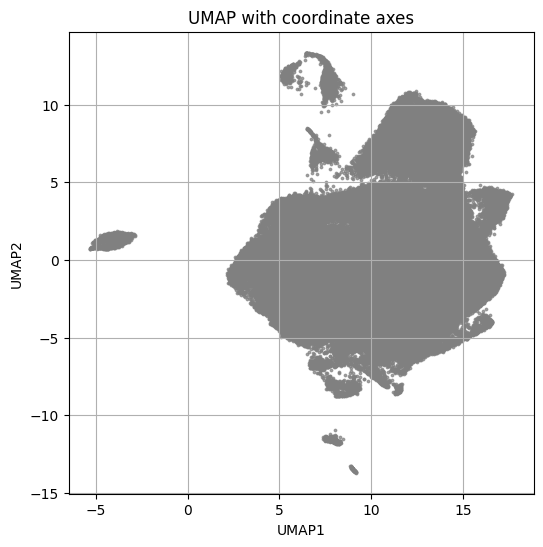

In [ ]:
# Normalize and reduce dimensionality
sc.pp.normalize_total(adata, target_sum=1e4)
# log-transform to deminish the influence of highly expressed genes
sc.pp.log1p(adata)  

# The most variable genes are the ones that give more biological info
sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)

# Scale so that gene variance is close to one
sc.pp.scale(adata)

# dimensionality reduction with PCA
sc.tl.pca(adata, svd_solver='arpack')

# UMAP embedding: fist you calculate a graph of neighbours then a 2D plot is created
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# Plot by target gene (perturbation)
umap = adata.obsm["X_umap"]
x, y = umap[:, 0], umap[:, 1]

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=1, c='gray', alpha=0.7)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP with coordinate axes")
plt.grid(True)
plt.show()


Filtered cells: 218841 of 221273 total


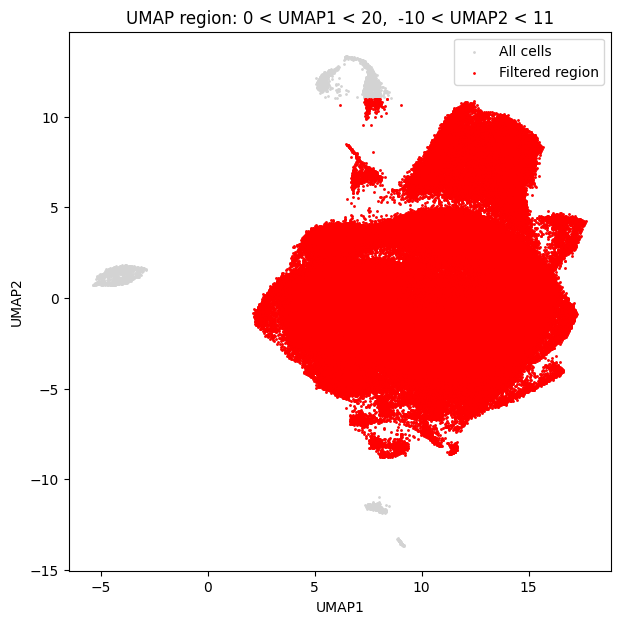

In [20]:
# adata.obsm['X_umap']
adata.obs['UMAP1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP2'] = adata.obsm['X_umap'][:, 1]

adata.obs[['UMAP1', 'UMAP2']].describe()

# Make sure UMAP coordinates are stored in the obs table
adata.obs['UMAP1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP2'] = adata.obsm['X_umap'][:, 1]

# Filter cells based on UMAP coordinate ranges
adata_filtered = adata[
    (adata.obs['UMAP1'] >= 0) & (adata.obs['UMAP1'] <= 20) &
    (adata.obs['UMAP2'] >= -10) & (adata.obs['UMAP2'] <= 11)
].copy()

print(f"Filtered cells: {adata_filtered.n_obs} of {adata.n_obs} total")

# Plot to visualize the selection
plt.figure(figsize=(7, 7))
plt.scatter(adata.obs['UMAP1'], adata.obs['UMAP2'], s=1, color='lightgray', label='All cells')
plt.scatter(adata_filtered.obs['UMAP1'], adata_filtered.obs['UMAP2'], s=1, color='red', label='Filtered region')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP region: 0 < UMAP1 < 20,  -10 < UMAP2 < 11")
plt.legend()
plt.show()

C:\Users\mikga\AppData\Local\Temp\ipykernel_19512\931462433.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('target_gene')[['UMAP1', 'UMAP2']]


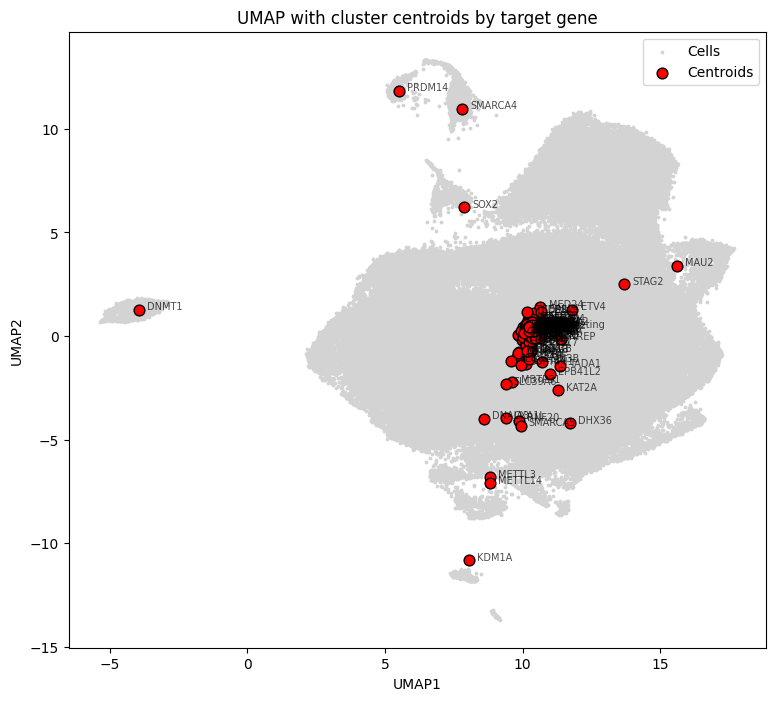

In [ ]:
# Ensure UMAP coordinates exist in obs
adata.obs['UMAP1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP2'] = adata.obsm['X_umap'][:, 1]

# Compute centroids (mean UMAP coordinates) per target_gene
centroids = (
    adata.obs.groupby('target_gene')[['UMAP1', 'UMAP2']]
    .mean()
    .reset_index()
)

# Plot: all cells in gray, centroids in color
plt.figure(figsize=(9, 8))
plt.scatter(adata.obs['UMAP1'], adata.obs['UMAP2'], s=3, color='lightgray', label='Cells')

# Plot each centroid
plt.scatter(centroids['UMAP1'], centroids['UMAP2'], s=60, c='red', edgecolor='black', label='Centroids')

# Optionally, label centroids with gene names
for _, row in centroids.iterrows():
    plt.text(row['UMAP1'] + 0.3, row['UMAP2'], row['target_gene'], fontsize=7, alpha=0.7)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP with cluster centroids by target gene")
plt.legend()
plt.show()


C:\Users\mikga\AppData\Local\Temp\ipykernel_19512\3124715425.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('target_gene')[['UMAP1', 'UMAP2']]


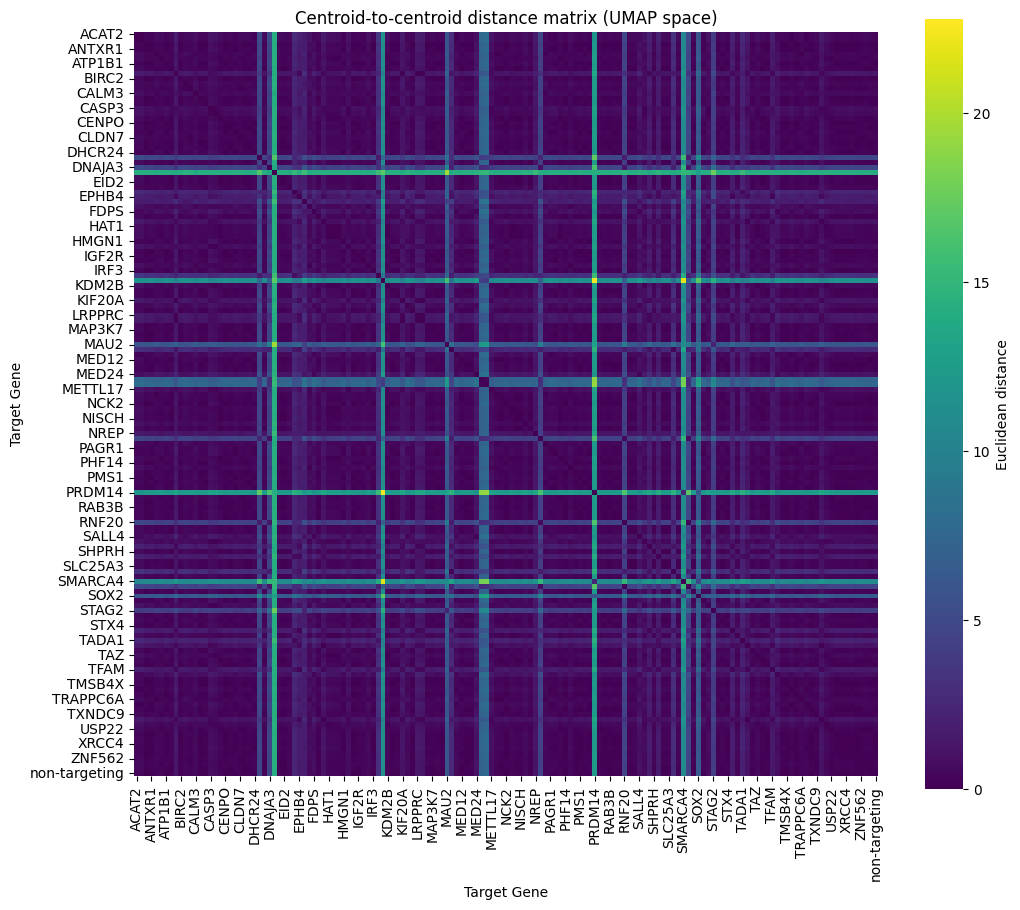


🔹 Top 10 most distant centroid pairs:

target_gene  target_gene
KDM1A        PRDM14         22.794390
PRDM14       KDM1A          22.794390
SMARCA4      KDM1A          21.791030
KDM1A        SMARCA4        21.791030
DNMT1        MAU2           19.642909
MAU2         DNMT1          19.642909
METTL14      PRDM14         19.233657
PRDM14       METTL14        19.233657
METTL3       PRDM14         18.941569
PRDM14       METTL3         18.941569
dtype: float64


In [ ]:
# Ensure UMAP coordinates are in obs
adata.obs['UMAP1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP2'] = adata.obsm['X_umap'][:, 1]

# Compute centroids per target gene
centroids = (
    adata.obs.groupby('target_gene')[['UMAP1', 'UMAP2']]
    .mean()
    .reset_index()
)

# Compute pairwise Euclidean distances between centroids
distance_matrix = pd.DataFrame(
    squareform(pdist(centroids[['UMAP1', 'UMAP2']], metric='euclidean')),
    index=centroids['target_gene'],
    columns=centroids['target_gene']
)

# Show as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, cmap="viridis", square=True, cbar_kws={'label': 'Euclidean distance'})
plt.title("Centroid-to-centroid distance matrix (UMAP space)")
plt.xlabel("Target Gene")
plt.ylabel("Target Gene")
plt.show()

# Optional: display top 10 most distant centroids
dist_unstacked = distance_matrix.unstack().sort_values(ascending=False)
top_pairs = dist_unstacked[dist_unstacked.index.get_level_values(0) != dist_unstacked.index.get_level_values(1)].head(10)
print("\n🔹 Top 10 most distant centroid pairs:\n")
print(top_pairs)


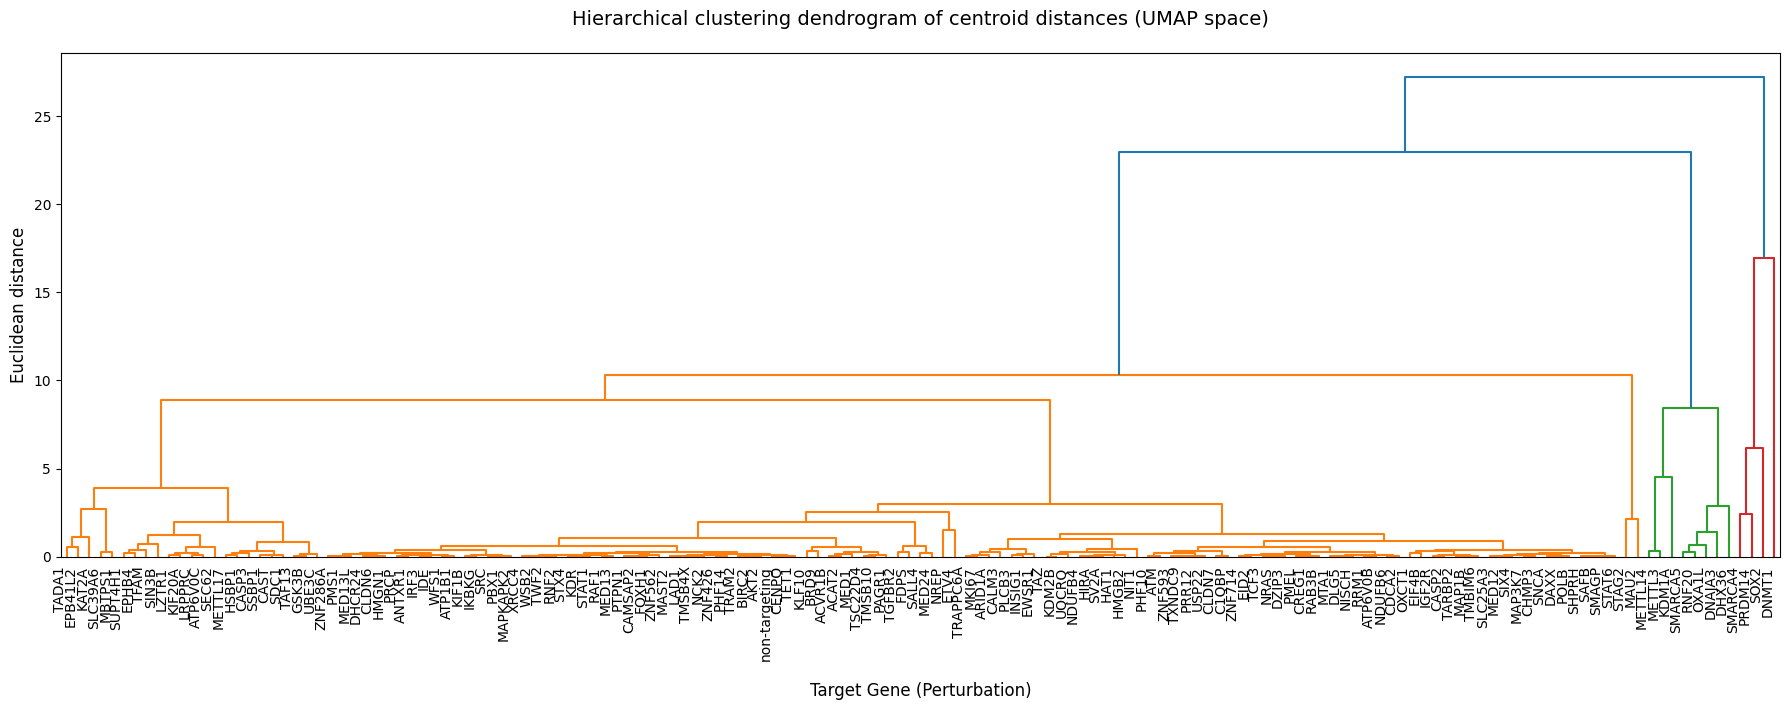

In [24]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))  # Increase width for spacing

dendrogram(
    Z,
    labels=centroids.index.tolist(),
    leaf_rotation=90,       # Rotate labels for readability
    leaf_font_size=10,      # Larger font
    color_threshold=0.7 * np.max(Z[:, 2]),
    distance_sort='descending',
)

plt.title("Hierarchical clustering dendrogram of centroid distances (UMAP space)", fontsize=14, pad=20)
plt.xlabel("Target Gene (Perturbation)", fontsize=12, labelpad=15)
plt.ylabel("Euclidean distance", fontsize=12)
plt.xticks(rotation=90, ha='right')

# Increase spacing between labels and bottom of plot
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()